# Notebook setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import numpy as np
import matplotlib.pyplot as plt

import os
import sys

sys.path.insert(1, '../')

from moments_toolkit import moments_toolkit

# Data reading

In [2]:
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW/3PointCorrelation/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW/2PointCorrelation/"


opAnalyzer = moments_toolkit(p3fold, p2fold,
                            T_to_remove_list=[12], skip3p=False, skipop=False,
                            verbose=True,
                            fast_data_folder = "../fast_data",
                            operator_folder= "../operator_database",
                            max_n=3)


Initializing the moments_toolkit class instance...


Initializing the building block class instance...


Reading the the keys of the dataset ...


Reading the 2 point and 3 point correlators from the fast access dataset ...


Reading the list of all the available operators from the database...


Class Initialization Complete!



# Ratio Plot - Attempt 1

## Operator selection

In [3]:
#we take the operators of the paper

opV1 = 1/6 * opAnalyzer.get_operator(2)
opV2 = 1/(3 * np.sqrt(2)) * (opAnalyzer.get_operator(2) - opAnalyzer.get_operator(3))
opV3 = 1/np.sqrt(2) * opAnalyzer.get_operator(14)

opA1 = 1/np.sqrt(2) * opAnalyzer.get_operator(28)
opA2 = 1/np.sqrt(2) * opAnalyzer.get_operator(32)

opT1 = opAnalyzer.get_operator(74) + 1/2 * opAnalyzer.get_operator(78)
opT2 = opAnalyzer.get_operator(78)
opT3 =  1/6 * ( -3 * opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) + 3* opAnalyzer.get_operator(91) + opAnalyzer.get_operator(95) )
opT4 = 1/2 * ( opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) -2* opAnalyzer.get_operator(91) )

In [4]:
"V"
(opV1*6).O
(opV2*np.sqrt(2)).O
(opV3*np.sqrt(2)).O
"A"
(opA1*np.sqrt(2)).O
(opA2*np.sqrt(2)).O
"T"
opT1.O
opT2.O
opT3.O
opT4.O

'V'

1.0*O[1, 1] + 1.0*O[2, 2] + 1.0*O[3, 3] - 3.0*O[4, 4]

1.0*O[3, 3] - 1.0*O[4, 4]

1.0*O[1, 4] + 1.0*O[4, 1]

'A'

1.0*O[1, 3] + 1.0*O[3, 1]

1.0*O[3, 4] + 1.0*O[4, 3]

'T'

1.0*O[2, 1, 1] - 1.0*O[2, 4, 4]

1.0*O[2, 3, 3] - 1.0*O[2, 4, 4]

1.0*O[1, 2, 4] - 1.0*O[2, 4, 1]

1.0*O[1, 4, 2] - 2.0*O[2, 1, 4] + 1.0*O[4, 2, 1]

In [5]:
#(2* opAnalyzer.get_operator(87)).O
#opAnalyzer.get_operator(91).O
#opAnalyzer.get_operator(95).O
#
#
#
#2 * opAnalyzer.get_operator(87) - 2 * opAnalyzer.get_operator(95) + 3 * opAnalyzer.get_operator(83)
#
#
#
#
#opAnalyzer.get_operator(83).O
#(2 * opAnalyzer.get_operator(87)).O
#opAnalyzer.get_operator(91).O
#opAnalyzer.get_operator(95).O
#
#
#
#
#(-3 * opAnalyzer.get_operator(83)).O
#(2 * opAnalyzer.get_operator(87)).O
#(3* opAnalyzer.get_operator(91)).O
#opAnalyzer.get_operator(95).O
#
#
#(-3 * opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) + 3* opAnalyzer.get_operator(91) + opAnalyzer.get_operator(95) ).O
#
#
#
#( opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) -2* opAnalyzer.get_operator(91) ).O

In [6]:
#we empty the selected op just to be sure
opAnalyzer.deselect_operator()

#we append the operators
opAnalyzer.append_operator(opV1)
opAnalyzer.append_operator(opV2)
opAnalyzer.append_operator(opV3)
opAnalyzer.append_operator(opA1)
opAnalyzer.append_operator(opA2)
opAnalyzer.append_operator(opT1)
opAnalyzer.append_operator(opT2)
opAnalyzer.append_operator(opT3)
opAnalyzer.append_operator(opT4)

opAnalyzer.selected_op

[O[1, 1]/6 + O[2, 2]/6 + O[3, 3]/6 - O[4, 4]/2,
 707106781186547*O[3, 3]/1000000000000000 - 707106781186547*O[4, 4]/1000000000000000,
 707106781186547*O[1, 4]/1000000000000000 + 707106781186547*O[4, 1]/1000000000000000,
 707106781186547*O[1, 3]/1000000000000000 + 707106781186547*O[3, 1]/1000000000000000,
 707106781186547*O[3, 4]/1000000000000000 + 707106781186547*O[4, 3]/1000000000000000,
 O[2, 1, 1] - O[2, 4, 4],
 O[2, 3, 3] - O[2, 4, 4],
 O[1, 2, 4] - O[2, 4, 1],
 O[1, 4, 2] - 2*O[2, 1, 4] + O[4, 2, 1]]

## Ratios

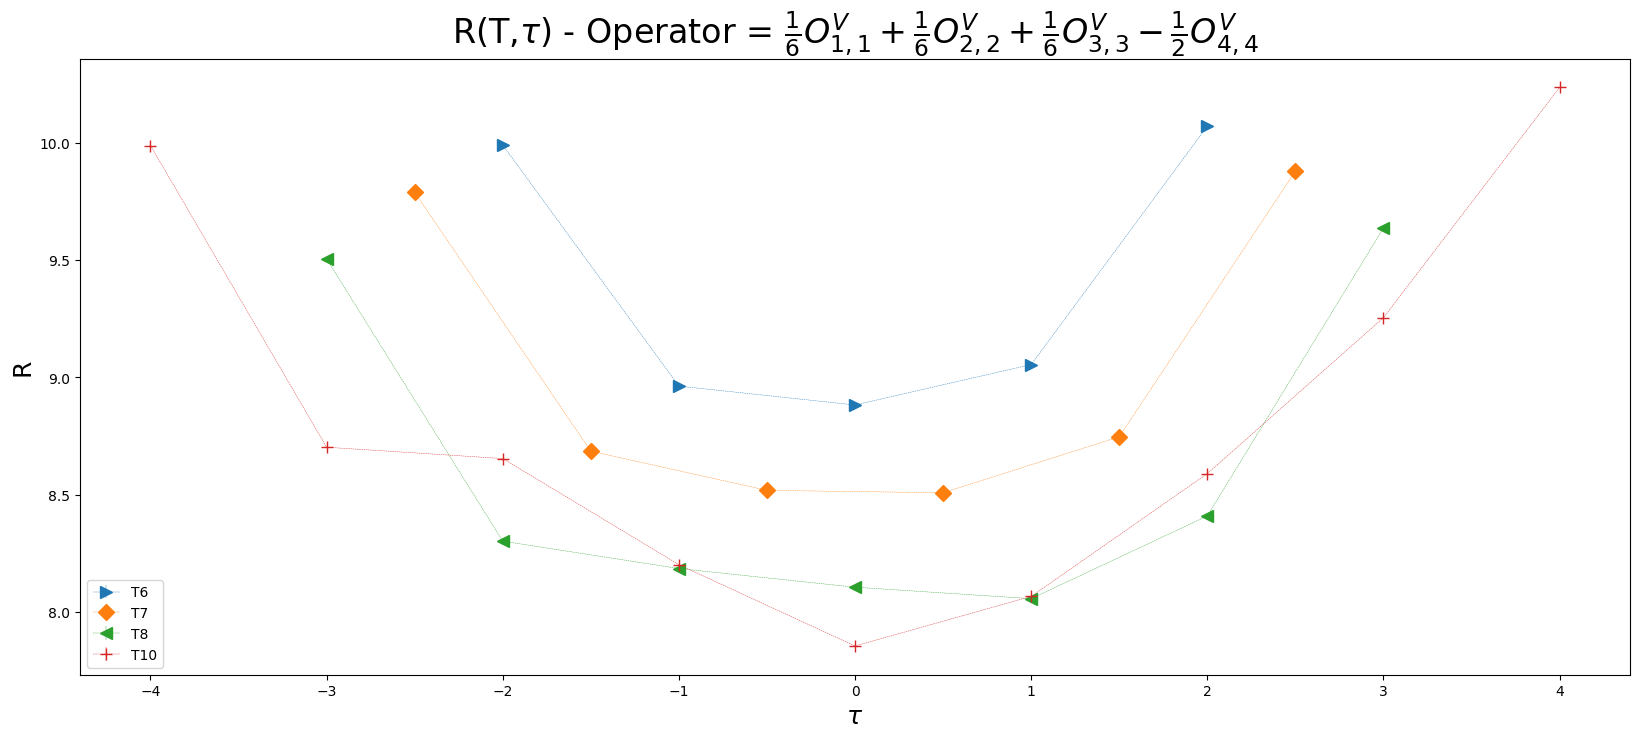

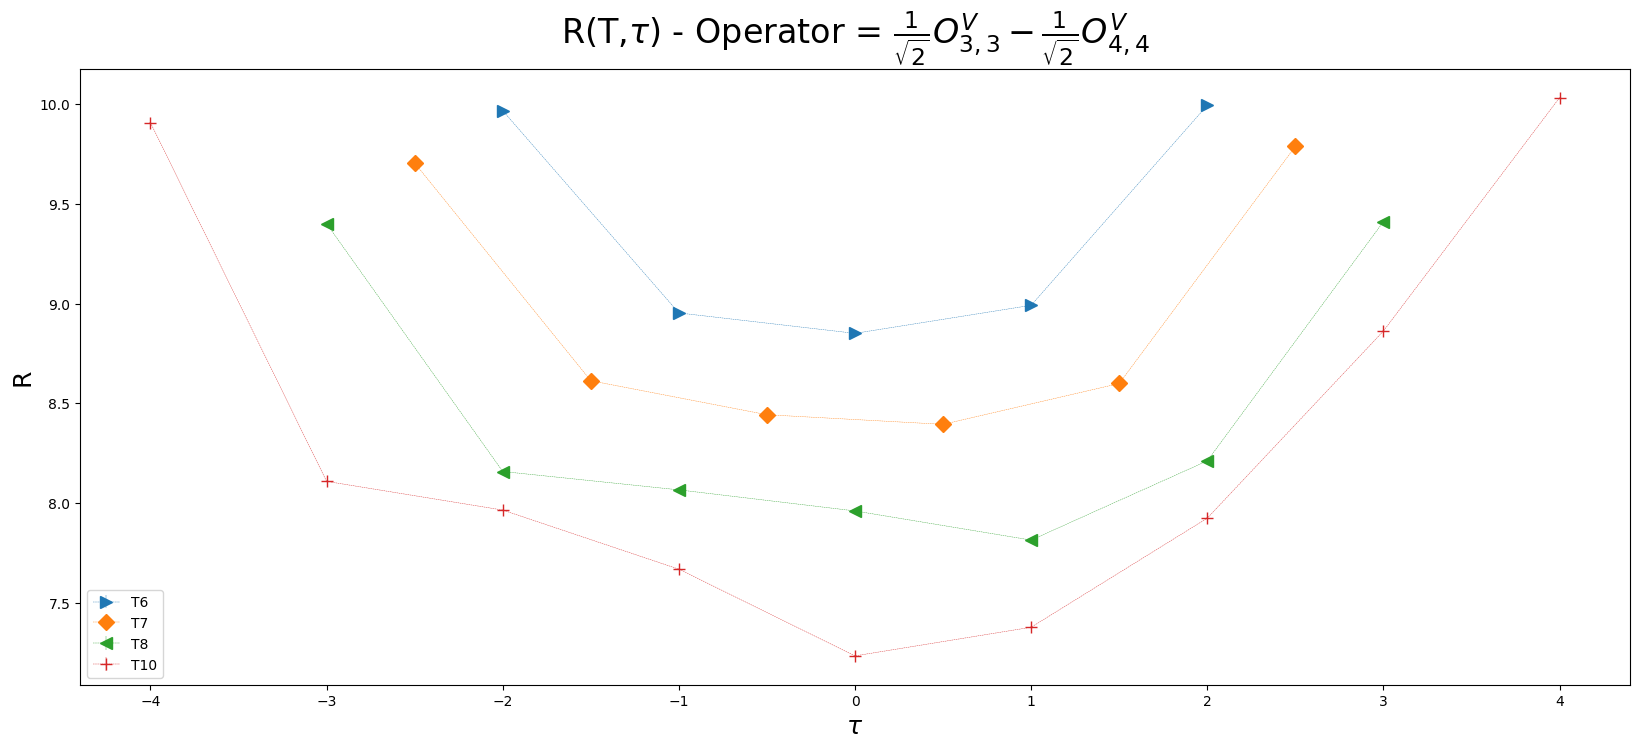

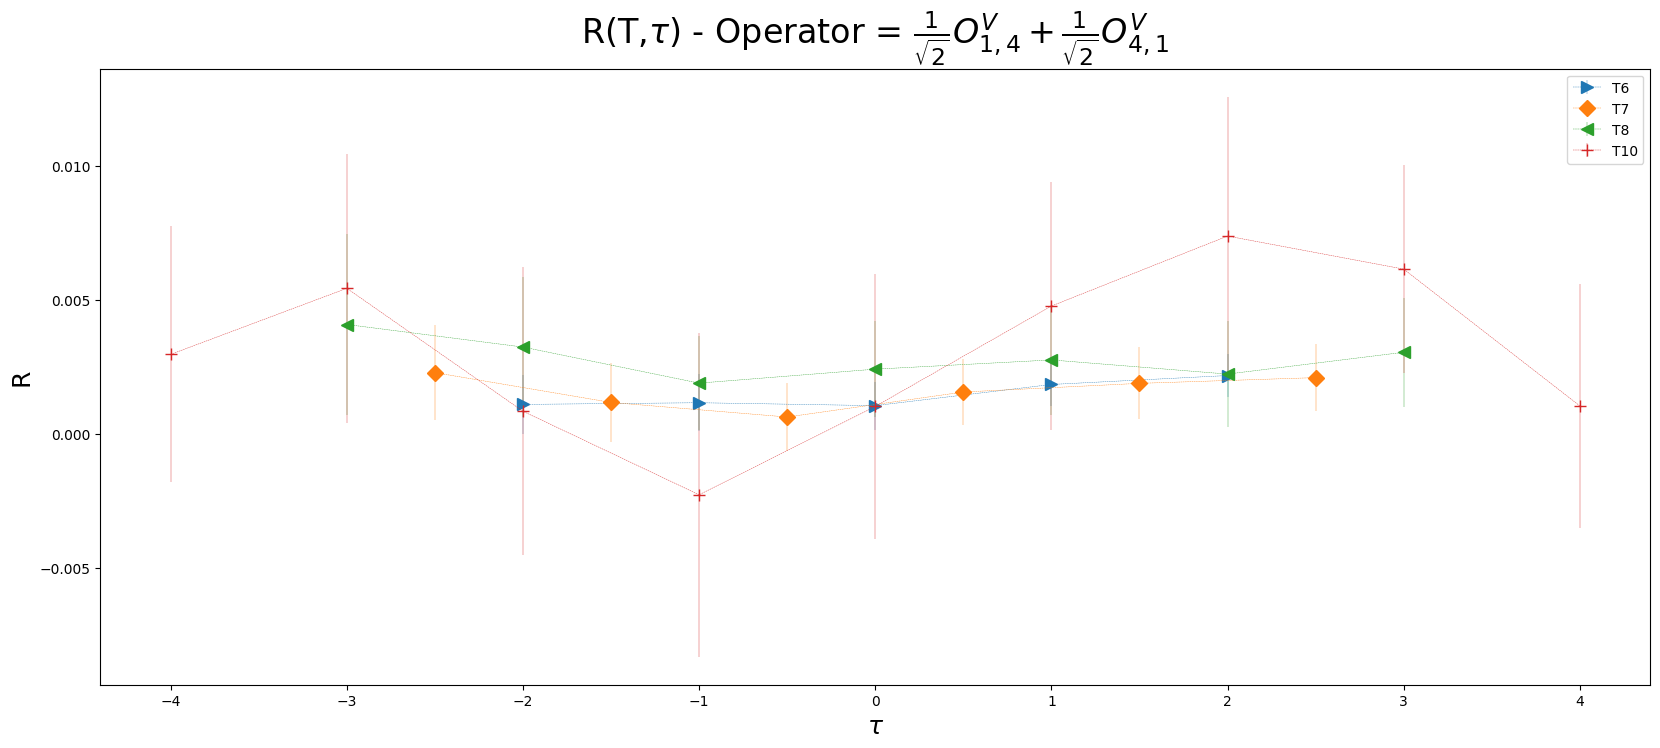

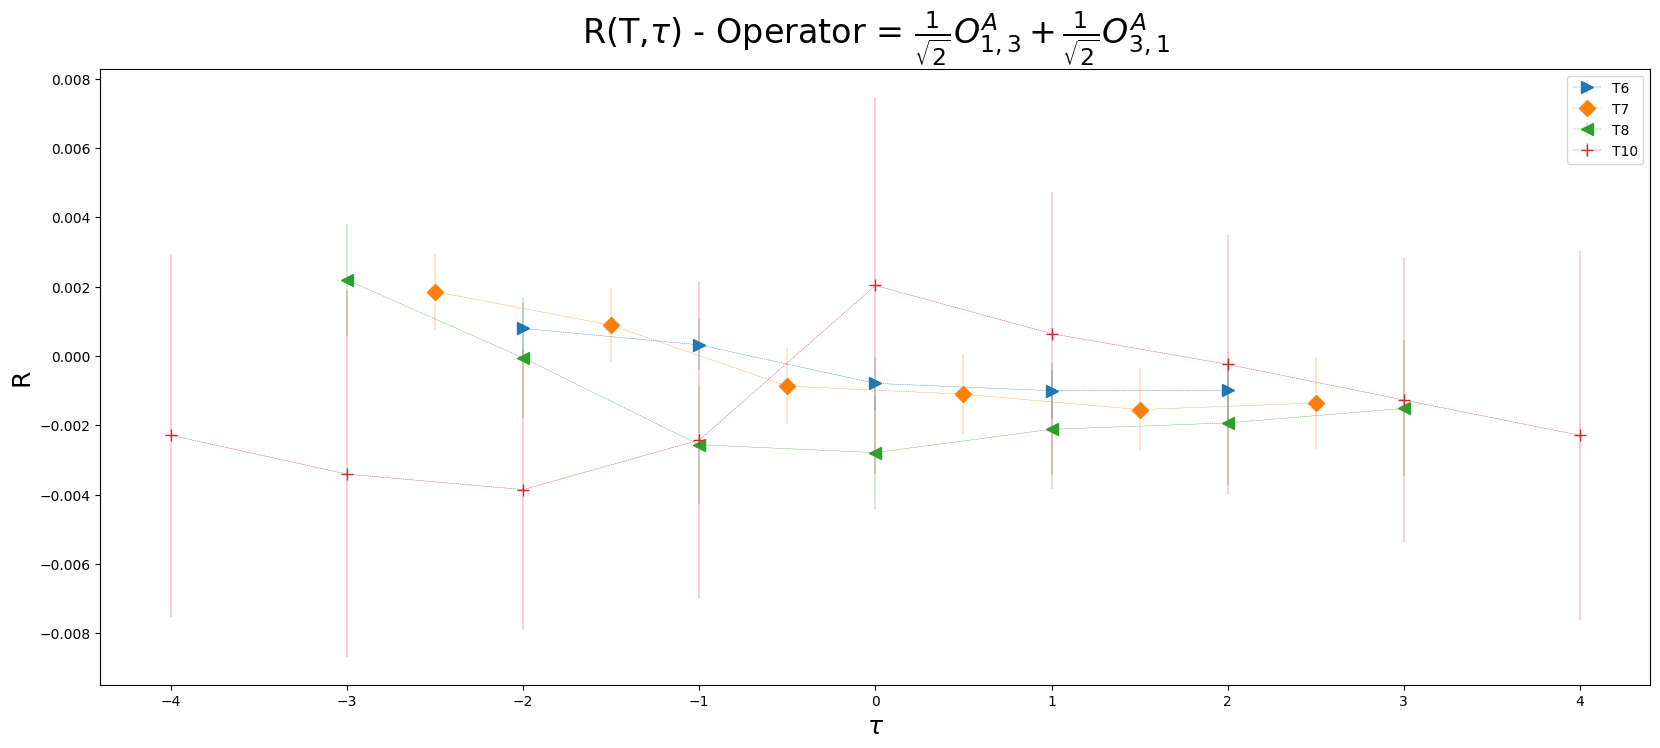

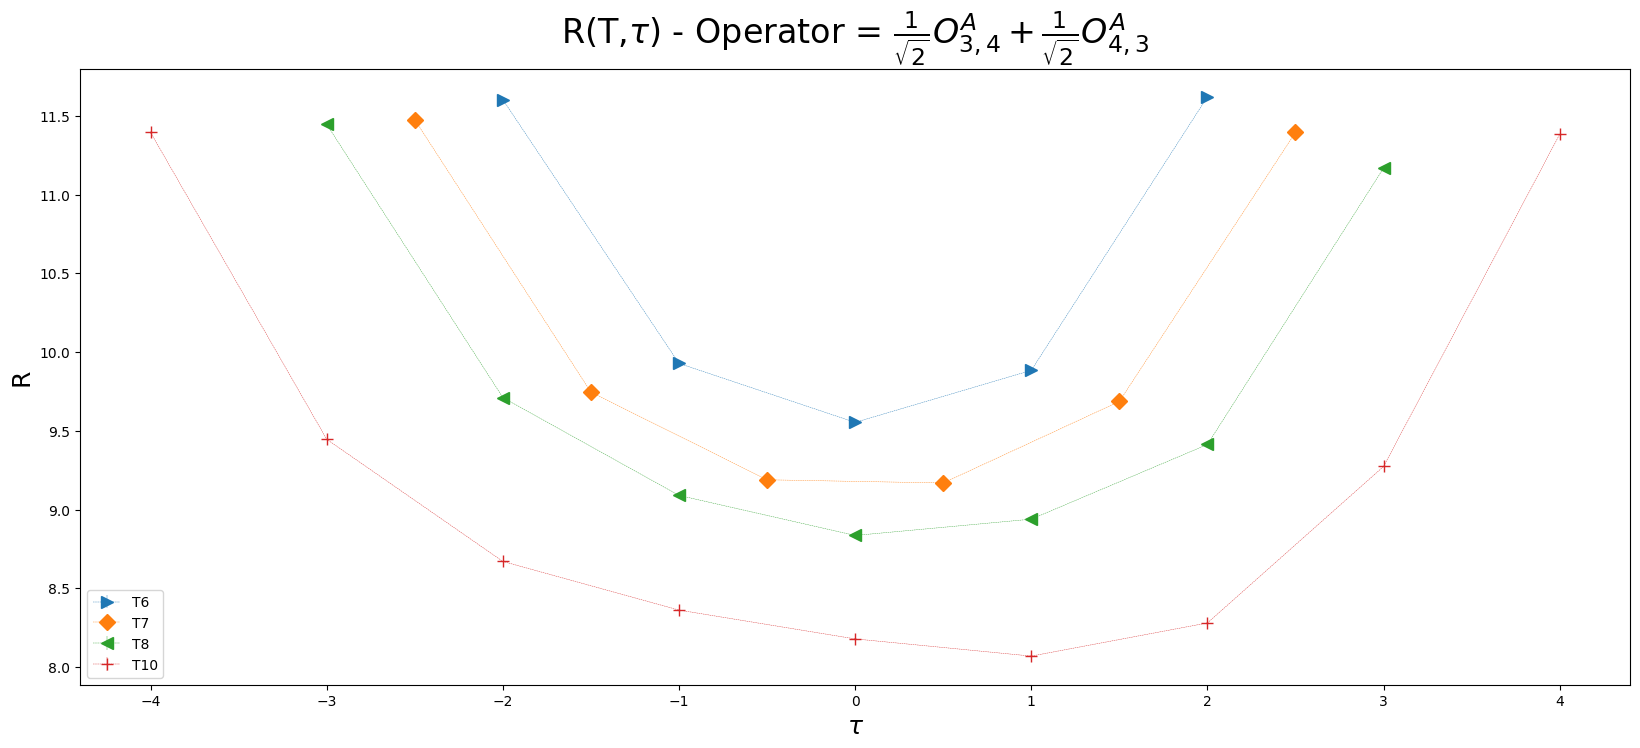

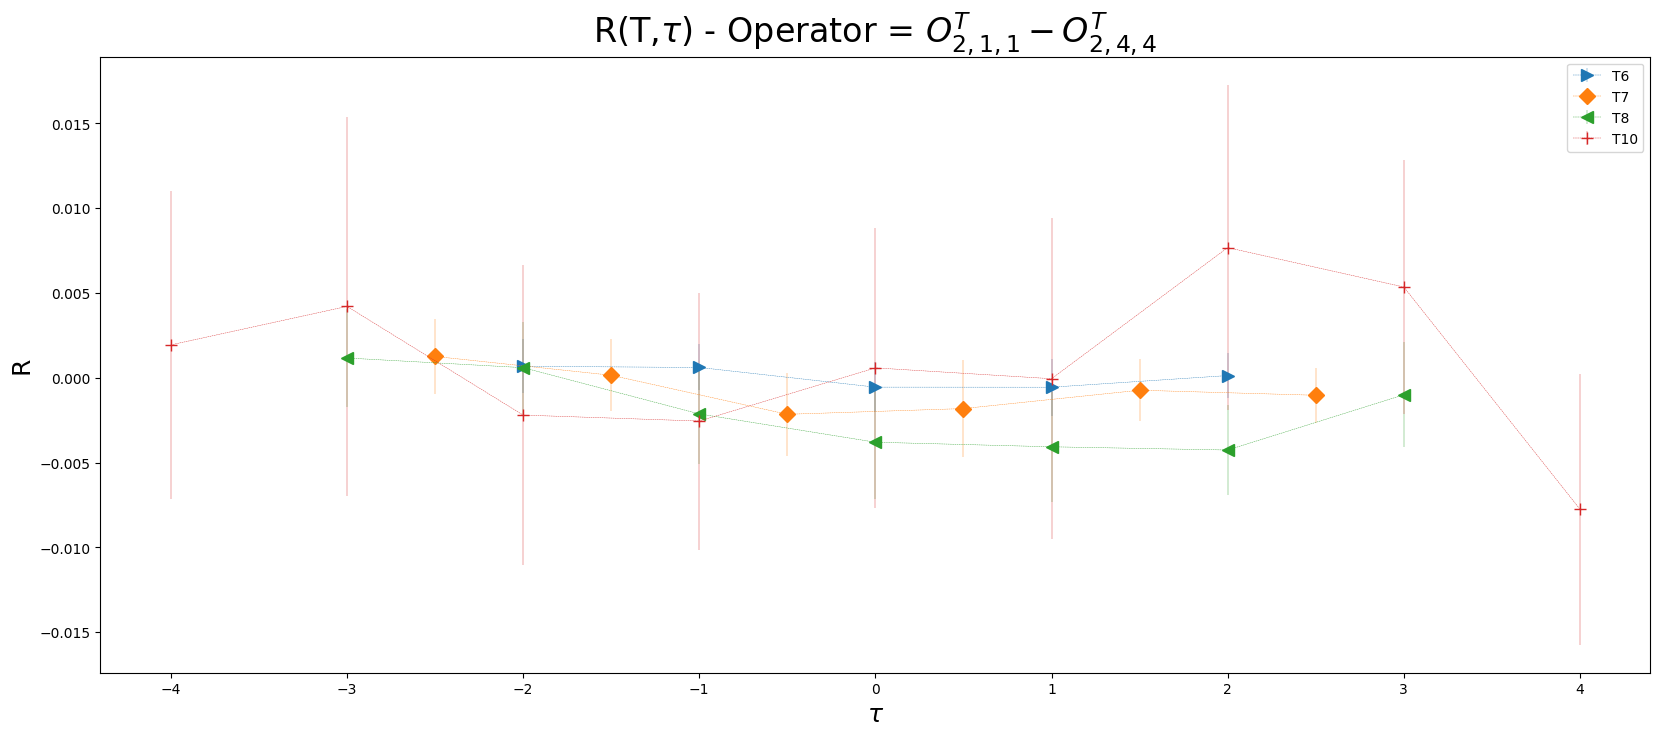

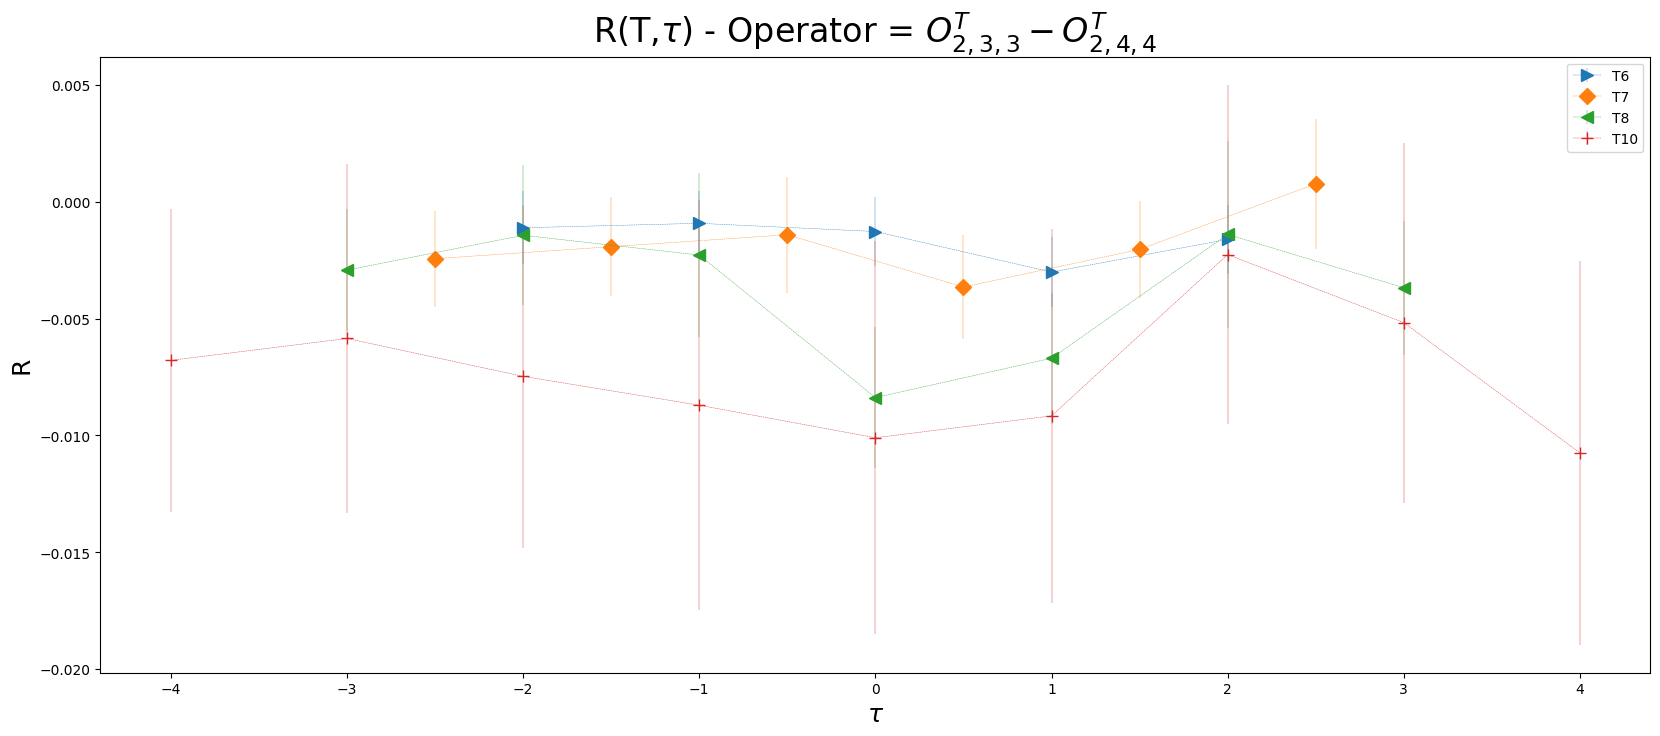

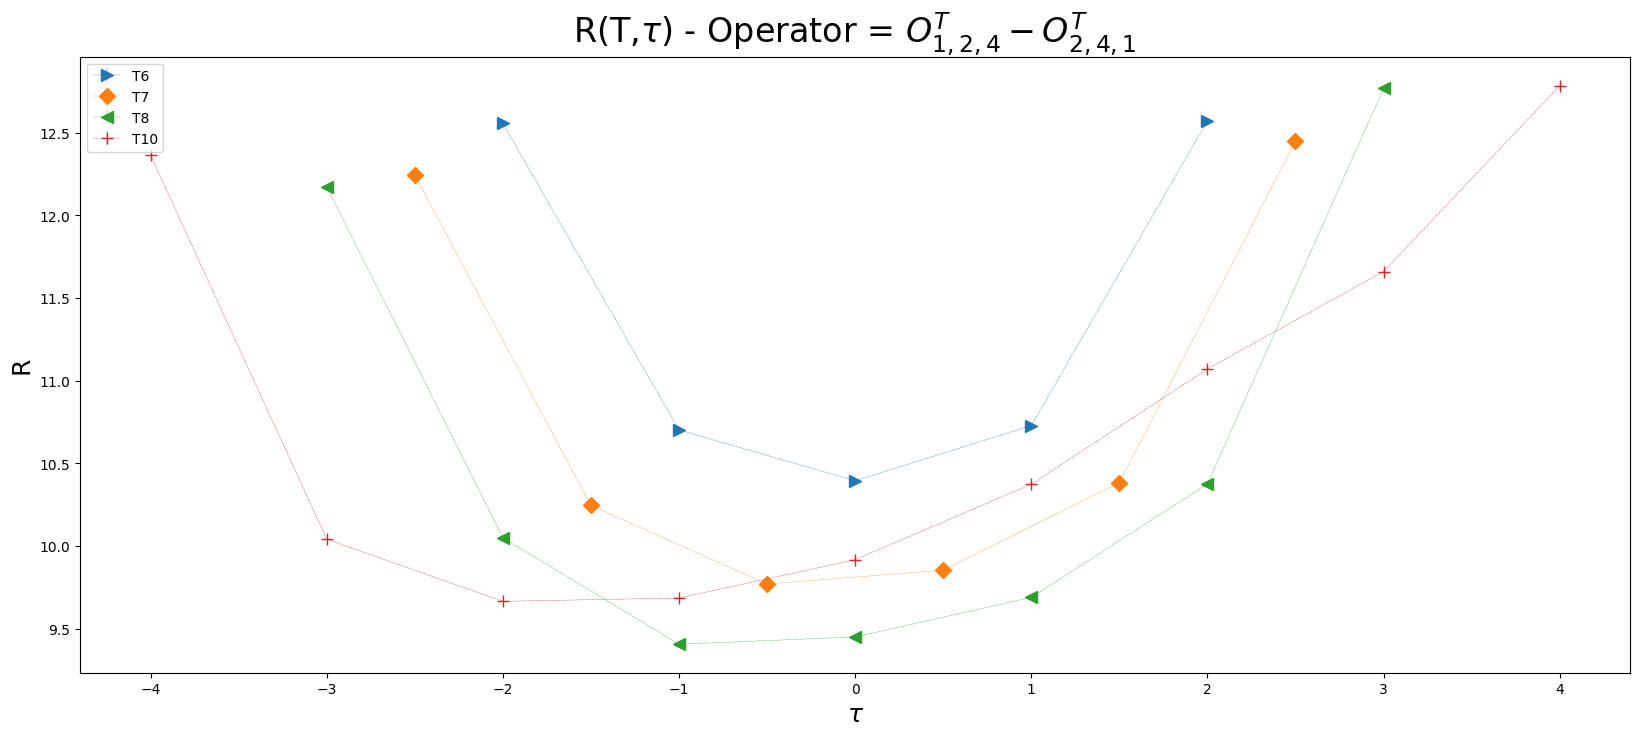

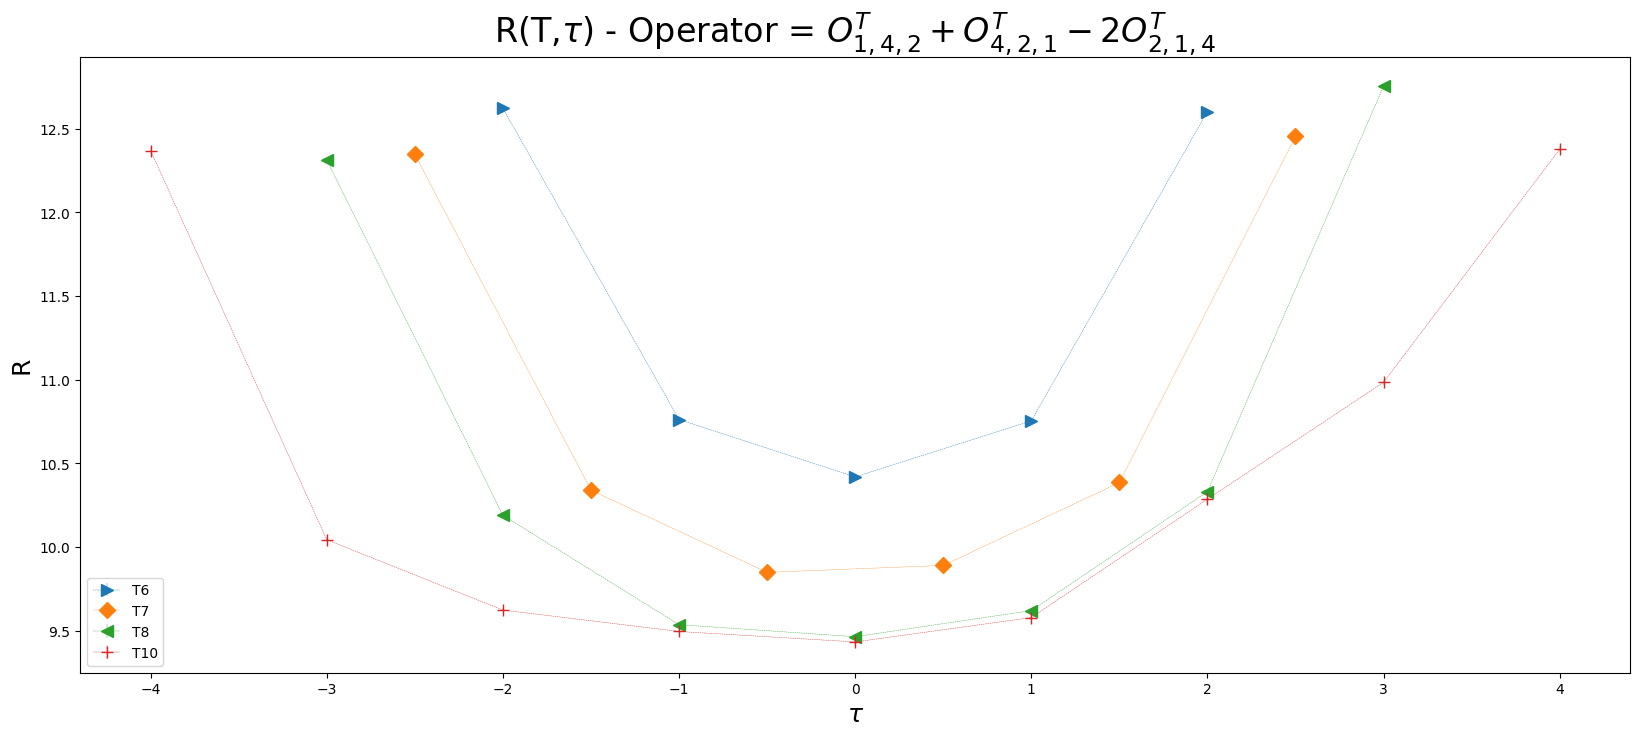

In [7]:
opAnalyzer.plot_R(rescale=True)

In [8]:
fit_state = opAnalyzer.fit_2pcorr(zoom=5,show=False,save=False)

In [9]:
par = fit_state.model_average()
par.keys()
par['est']['E0']


a = 0.1163

par['est']['E0'] /a * 197.327

1000/197.327 * a

dict_keys(['est', 'err'])

np.float64(0.6987413871543884)

np.float64(1185.559257979484)

0.5893770239247543

# Fit: $\mathcal{M}$ from $R$

In [10]:
R, Rmean, Rstd, Rcovmat = opAnalyzer.get_R()

"(Nop, Nconf, NT, max(T)+1 )"
R.shape 

'(Nop, Nconf, NT, max(T)+1 )'

(9, 212, 4, 11)

In [11]:
iop = 0
iconf = 0
iT = 0
iT_value = opAnalyzer.T_list[iT] # = 6 for iT=0


R[0,0,iT,:iT_value+1]

tskip = 1


R[0,0,iT,tskip:iT_value+1-tskip]

array([-0.04231533,  0.07639338,  0.07763667,  0.08015658,  0.0783448 ,
        0.09187109, -0.02320183])

array([0.07639338, 0.07763667, 0.08015658, 0.0783448 , 0.09187109])

In [12]:
S, Smean, Sstd = opAnalyzer.get_S(tskip=1)

"(Nop, Nconf, NT)"
S.shape

"(Nop, NT)"
Smean.shape

"(Nop, NT)"
Sstd.shape

'(Nop, Nconf, NT)'

(9, 212, 4)

'(Nop, NT)'

(9, 4)

'(Nop, NT)'

(9, 4)

In [13]:
from moments_toolkit import sum_ratios

In [14]:
tskip_list = [1,2,3]

S_list = np.zeros(shape=(len(opAnalyzer.selected_op), opAnalyzer.nconf, len(opAnalyzer.T_list), len(tskip_list)), # = (Nop, Nconf, NT, Ntskip)
               dtype=float)

for i_tskip, tskip in enumerate(tskip_list):

    S_list[:,:,:,i_tskip], _, _ = opAnalyzer.get_S(tskip=tskip)

In [15]:
delta = 1
iT = 0 

MatEle = ( S_list[:,:,iT+delta,:] - S_list[:,:,iT,:] ) / delta

"(Nop, Nconf, Ntskip)"
MatEle.shape

'(Nop, Nconf, Ntskip)'

(9, 212, 3)

In [16]:
opAnalyzer.T_list

[6, 7, 8, 10]

In [17]:
delta_list = [1,2,3]

MatEle_list = []

for iT, iT_value in enumerate(opAnalyzer.T_list):

    for delta in delta_list:
        
        if iT_value + delta in opAnalyzer.T_list:

            print(f"T={iT_value} - delta={delta}")

            iT_plus_delta = opAnalyzer.T_list.index(iT_value + delta)

            MatEle_list.append( (S_list[:,:,iT_plus_delta,:] - S_list[:,:,iT,:])/delta )

#len(MatEle_list)

MatEle_list = np.asarray( MatEle_list )

"(Nallowed, Nop, Nconf, Ntskip)"
MatEle_list.shape

T=6 - delta=1
T=6 - delta=2
T=7 - delta=1
T=7 - delta=3
T=8 - delta=2


'(Nallowed, Nop, Nconf, Ntskip)'

(5, 9, 212, 3)

In [18]:
MatEle_list.mean(axis=0).mean(axis=0).mean(axis=1)

array([ 0.13689866,  0.03489163,  0.02998567,  0.05511343,  0.02615796,
        0.04250643,  0.04980988,  0.10660952,  0.00103072,  0.02232661,
        0.05250478,  0.07608133,  0.06053998,  0.09342817,  0.00850935,
        0.07048116,  0.17842005,  0.07945986,  0.05290651,  0.03637961,
        0.0803321 , -0.03633381,  0.03407943,  0.06037906,  0.04308567,
        0.0653815 ,  0.11331322,  0.06811109,  0.0669869 ,  0.04355695,
        0.02624645,  0.06783022,  0.03563844,  0.04455521,  0.06832959,
        0.05621951,  0.01856541,  0.11107353,  0.05335547,  0.0616533 ,
        0.05844224,  0.07899468,  0.01956883,  0.08346447,  0.10615904,
        0.01652517,  0.0401477 , -0.01462073,  0.02703963,  0.01317704,
        0.06869284,  0.05374779,  0.02449538,  0.01730453,  0.03256718,
        0.03123149,  0.04001574,  0.01853184,  0.08695713,  0.04000854,
        0.02147445,  0.03904044,  0.05770319,  0.10171316,  0.04129312,
        0.04731027,  0.03930178,  0.04043462,  0.06760971,  0.06

In [19]:
np.mean(MatEle_list)

np.float64(0.055730878646972584)

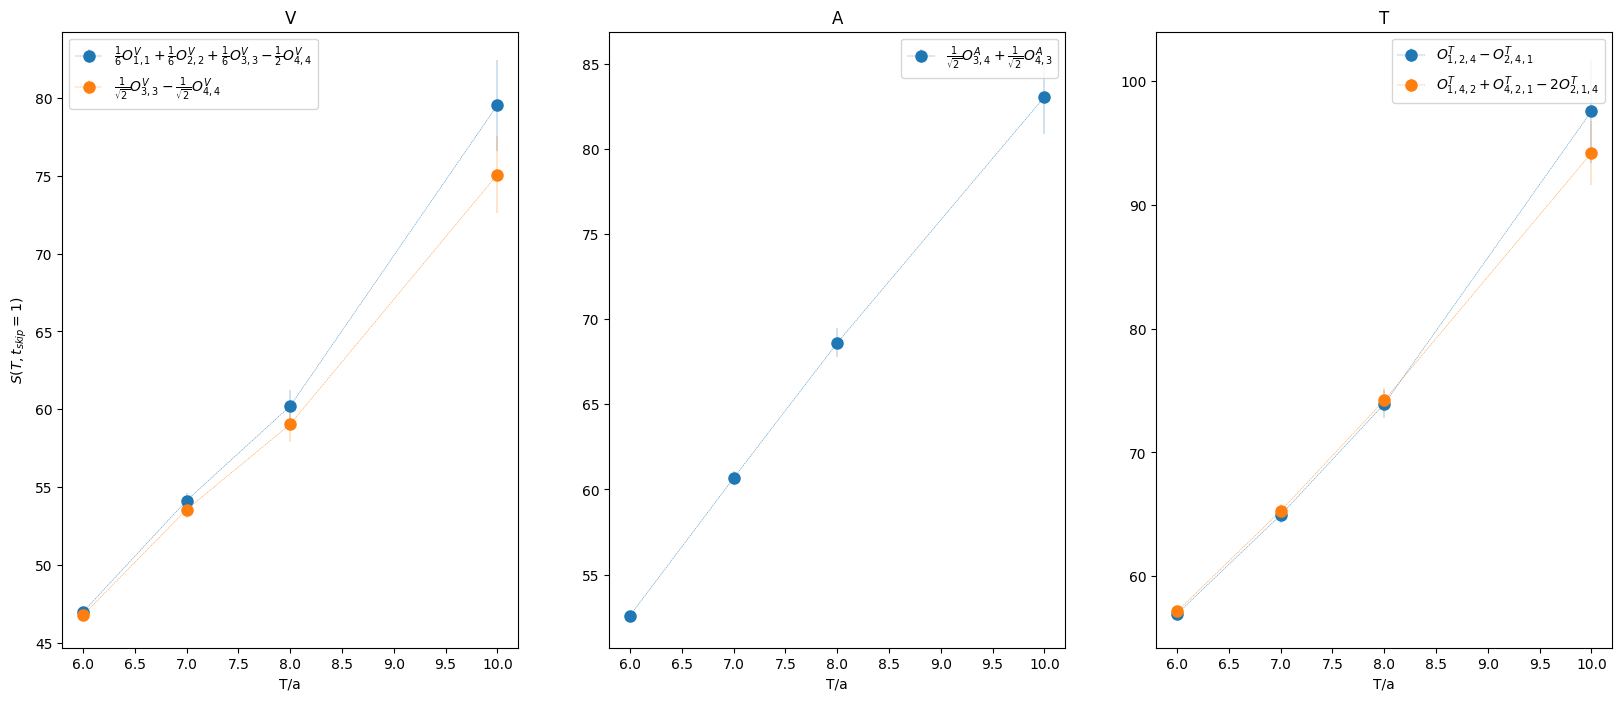

In [20]:
opAnalyzer.plot_S(tskip=1)

In [21]:
opV2.O

0.707106781186547*O[3, 3] - 0.707106781186547*O[4, 4]

In [22]:
import sympy as sym

(0.707106781186547*O[3, 3], -0.707106781186547*O[4, 4])

'ciao'

sympy.core.numbers.Float

'1'

'ciao'

sympy.core.numbers.Float

'1'

'1.0O^{V}_{2, 3, 3}-1.0O^{V}_{2, 4, 4}'

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, '$1.0O^{V}_{2, 3, 3}-1.0O^{V}_{2, 4, 4}$')

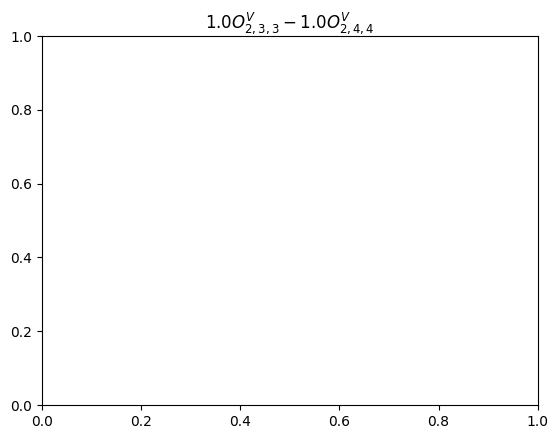

In [23]:
sym.Add.make_args(opV2.O)

lat_str = ""

sqrt_conv = {np.sqrt(2):r"\sqrt(2)", 1/np.sqrt(2): r"\frac{1}{\sqrt{2}}"}

for i, e in enumerate(sym.Add.make_args(opT2.O)):
    sign = e.as_coeff_mul()[0]
    coeff = e.as_coeff_mul()[1][0]
    symbol = e.as_coeff_mul()[1][1]

    #lat_str

    if sign==1 and i!=0:
        lat_str += "+"
    elif sign == -1:
        lat_str += "-"

    if coeff in sqrt_conv.keys():
        lat_str += sqrt_conv[coeff]
    else:
        if float(coeff) == 1:
            "ciao"
        lat_str += str(float(coeff))
        type(coeff)
        str(int(coeff))
    
    lat_str += str(symbol).replace('[','^{'+opV2.X+'}_{').replace(']','}')

lat_str

plt.figure()
plt.title(r"${}$".format(lat_str))
plt.show()

In [24]:
from math import gcd

def is_square(apositiveint):
  x = apositiveint // 2
  seen = set([x])
  while x * x != apositiveint:
    x = (x + (apositiveint // x)) // 2
    if x in seen: return False
    seen.add(x)
  return True

In [25]:
[gcd(i,j) for i in range(5) for j in range(5)]

[0, 1, 2, 3, 4, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 3, 1, 1, 3, 1, 4, 1, 2, 1, 4]

In [26]:
numerics_to_latex_conv = {}

for num in range(1,101):
    for den in range(2,101):
        
        #we append the frac num/den if they do not have common divisors
        if gcd(num,den)==1:
            numerics_to_latex_conv[num/den] = r"\frac{"+str(num)+r"}{"+str(den)+r"}"

        #we append num/sqrt(den) if the same key is not already there (due to simplification) and if den is not a perfect square
        if is_square(den) == False and num/np.sqrt(den) not in numerics_to_latex_conv.keys():
            numerics_to_latex_conv[num/np.sqrt(den)] = r"\frac{"+str(num)+r"}{\sqrt{"+str(den)+r"}}"

numerics_to_latex_conv

{0.5: '\\frac{1}{2}',
 np.float64(0.7071067811865475): '\\frac{1}{\\sqrt{2}}',
 0.3333333333333333: '\\frac{1}{3}',
 np.float64(0.5773502691896258): '\\frac{1}{\\sqrt{3}}',
 0.25: '\\frac{1}{4}',
 0.2: '\\frac{1}{5}',
 np.float64(0.4472135954999579): '\\frac{1}{\\sqrt{5}}',
 0.16666666666666666: '\\frac{1}{6}',
 np.float64(0.4082482904638631): '\\frac{1}{\\sqrt{6}}',
 0.14285714285714285: '\\frac{1}{7}',
 np.float64(0.3779644730092272): '\\frac{1}{\\sqrt{7}}',
 0.125: '\\frac{1}{8}',
 np.float64(0.35355339059327373): '\\frac{1}{\\sqrt{8}}',
 0.1111111111111111: '\\frac{1}{9}',
 0.1: '\\frac{1}{10}',
 np.float64(0.31622776601683794): '\\frac{1}{\\sqrt{10}}',
 0.09090909090909091: '\\frac{1}{11}',
 np.float64(0.30151134457776363): '\\frac{1}{\\sqrt{11}}',
 0.08333333333333333: '\\frac{1}{12}',
 np.float64(0.2886751345948129): '\\frac{1}{\\sqrt{12}}',
 0.07692307692307693: '\\frac{1}{13}',
 np.float64(0.2773500981126146): '\\frac{1}{\\sqrt{13}}',
 0.07142857142857142: '\\frac{1}{14}',
 np

In [ ]:
#opAnalyzer.operator_show()